In [1]:
import os
import cv2
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from skimage.feature import hog, match_template
from skimage import data, exposure
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from time import time
from shutil import copyfile
print("Packages Loaded")

Packages Loaded


In [2]:
##############################################################################################
#######################  Load Images  ########################################################
##############################################################################################
tic = time()

# File locations
excel_file = r"cars_classes.xlsx"
train_folder = r"cars_train\cars_train"
test_folder = r"cars_test\cars_test"
output_folder = r"cars_dataset"  # Folder for the combined dataset
excel_out = r"cars_classes_split.xlsx"

In [3]:
# Load training data
train_df = pd.read_excel(excel_file, sheet_name='train')

# Load testing data
test_df = pd.read_excel(excel_file, sheet_name='test')

In [4]:
# Function to label and copy images
def label_and_copy(df, image_folder, output_folder):
    for index, row in df.iterrows():
        image_name = row['image']  # Assuming 'image_name' column exists
        true_class_name = row['true_class_name']
        class_name = true_class_name.split()[0]
        source_path = os.path.join(image_folder, image_name)
        destination_path = os.path.join(output_folder, class_name, image_name)
        os.makedirs(os.path.join(output_folder, class_name), exist_ok=True)  # Create class folders
        copyfile(source_path, destination_path)

#label_and_copy(train_df, train_folder, output_folder)# Label and copy training images
#label_and_copy(test_df, test_folder, output_folder)# Label and copy testing images

def create_filtered_dataframe(dataset_path, brands):
  """
  Creates a Pandas DataFrame from a dataset folder,
  filtering for specific brands.

  Args:
    dataset_path: Path to the dataset folder.
    brands: List of brands to include.

  Returns:
    A Pandas DataFrame with image paths and labels.
  """

  data = []
  for brand in brands:
    brand_folder = os.path.join(dataset_path, brand)
    if os.path.isdir(brand_folder):
      for image_name in os.listdir(brand_folder):
        image_path = os.path.join(brand_folder, image_name)
        # image = cv2.imread(image_path)
        data.append({'image_path': image_path, 'brand': brand}) # 'image':image
  return pd.DataFrame(data)

In [5]:
# Specify the dataset path and desired brands
selected_brands = ['Chevrolet', 'BMW', 'Dodge', 'Audi']

# Create the filtered DataFrame
filtered_df = create_filtered_dataframe(output_folder, selected_brands)

# Display the DataFrame (optional)
filtered_df.head()

# Split the DataFrame into training and testing sets
train_df, test_df = train_test_split(filtered_df, test_size=0.3, random_state=42,stratify=filtered_df['brand'])

# Save the New DataFrames to the same xlsx files with two sheets
#with pd.ExcelWriter(excel_out) as writer:
#    train_df.to_excel(writer, sheet_name='train', index=False)
#    test_df.to_excel(writer, sheet_name='test', index=False)

print("Images Copied and Split in: ", time()-tic)

Images Copied and Split in:  9.656566381454468


In [6]:
# For each image in train_df load in the image and resize the image to 224x224
# Convert the image to a numpy array in RGP format
def load_jpg(image_path):
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    # Crop image so that it is square (DONT CHANGE ASPECT RATIO)
    h, w, _ = img.shape
    if h > w:
        img = img[(h-w)//2:(h+w)//2, :]
    else:
        img = img[:, (w-h)//2:(w+h)//2]
    img = cv2.resize(img, (224, 224))
    return img

def load_images(df):
    images = []
    Y = []
    for index, row in df.iterrows():
        img = load_jpg(row["image_path"])
        images.append(img)
        Y.append(row["brand"])
    return images, Y

train_images, targets = load_images(train_df)
test_images, labels = load_images(test_df)

In [7]:
print(len(train_images))
print(len(test_images))

3530
1513


In [7]:
##############################################################################################
#######################  Augment Images  #####################################################
##############################################################################################
tic = time()

def augment_images(images, targets):
    # OKAY TO FLIP IMAGES, but rotations and shearing will cause misalignment and probably not help blind
    # Missaligned edges (black space) a problem downstream? YES
    augmented_images = []
    augmented_target = []
    for i in range(len(images)):
        img = images[i]
        img = cv2.flip(img, 1)
        ### Consider Adding Contrast Normalization if the training data isn't large enough
        augmented_images.append(img)
        augmented_target.append(targets[i])
    return augmented_images, augmented_target

# # Plot the Augmented Images and their labels
augmented_images, augmented_targets = augment_images(train_images, targets)


train_images.extend(augmented_images)
targets.extend(augmented_targets)

print("Images Augmented in: ", time()-tic)

Images Augmented in:  0.19103026390075684


In [8]:
print(train_images[0].size)
print(test_images[0].size)

150528
150528


In [9]:
##############################################################################################
#######################  Feature Building ####################################################
##############################################################################################
'''
HOG transform, Forrier Transform, and Canny Edge Detect on images, save features as seperate Arrays
'''
tic = time()

def hog_features(images):
    hog_features = []
    for img in images:
        #fd, hog_feature = hog(img, orientations=8, pixels_per_cell=(16, 16), visualize=True,
        #                   cells_per_block=(1, 1), channel_axis=-1) # Uncomment to viusalize HOG feature
        hog_feature = hog(img, orientations=8, pixels_per_cell=(16, 16),
                           cells_per_block=(1, 1), channel_axis=-1)
        #hog_image_rescaled = exposure.rescale_intensity(hog_feature, in_range=(0, 10))
        hog_features.append(hog_feature)
    return hog_features

def fourier_features(images):
    fourier_features = []
    [ydim, xdim, zdim] = images[0].shape
    win = np.outer(np.hanning(ydim), np.hanning(xdim))
    win = win / np.mean(win)
    for img in images:
        gray_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        F = np.fft.fftshift(np.fft.fft2(gray_img*win))
        Fmag = np.abs(F)
        fourier_features.append(Fmag)
    return fourier_features

def canny_features(images):
    canny_features = []
    for img in images:
        canny = cv2.Canny(img, 100, 200)
        canny_features.append(canny)
    return canny_features

train_hog = hog_features(train_images)
train_fourier = fourier_features(train_images)
train_canny = canny_features(train_images)

test_hog = hog_features(test_images)
test_fourier = fourier_features(test_images)
test_canny = canny_features(test_images)


print("Features Built in: ", time()-tic)

Features Built in:  141.14855575561523


C:\Users\jcf03\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
C:\Users\jcf03\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


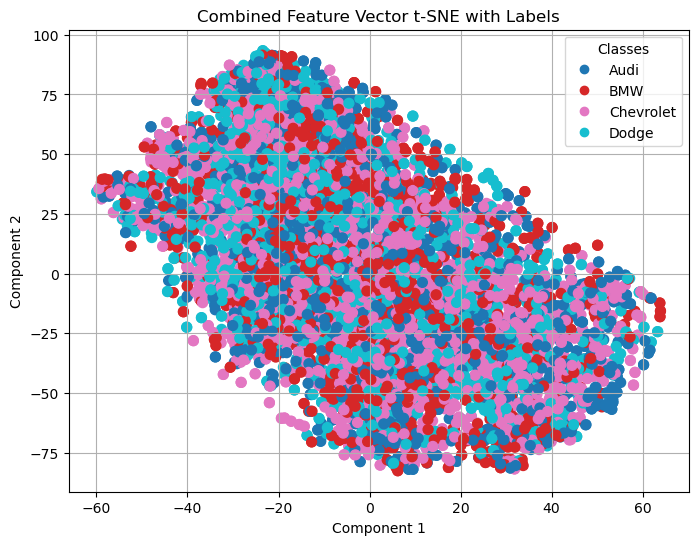

In [16]:
from sklearn.manifold import TSNE
from sklearn.preprocessing import LabelEncoder

tsne = TSNE(n_components=2, perplexity=30, n_iter=1000, random_state=42)
tsne_results = tsne.fit_transform(train_concat_features)

le = LabelEncoder()
numeric_labels = le.fit_transform(targets)
label_names = le.classes_

plt.figure(figsize=(8, 6))
scatter = plt.scatter(tsne_results[:, 0], tsne_results[:, 1], c=numeric_labels, cmap='tab10', s=50)
handles, indices = scatter.legend_elements()
legend_labels = [label_names[i] for i in range(len(handles))]
plt.legend(handles, legend_labels, title="Classes")
plt.title("Combined Feature Vector t-SNE with Labels")
plt.xlabel("Component 1")
plt.ylabel("Component 2")
plt.grid(True)
plt.show()

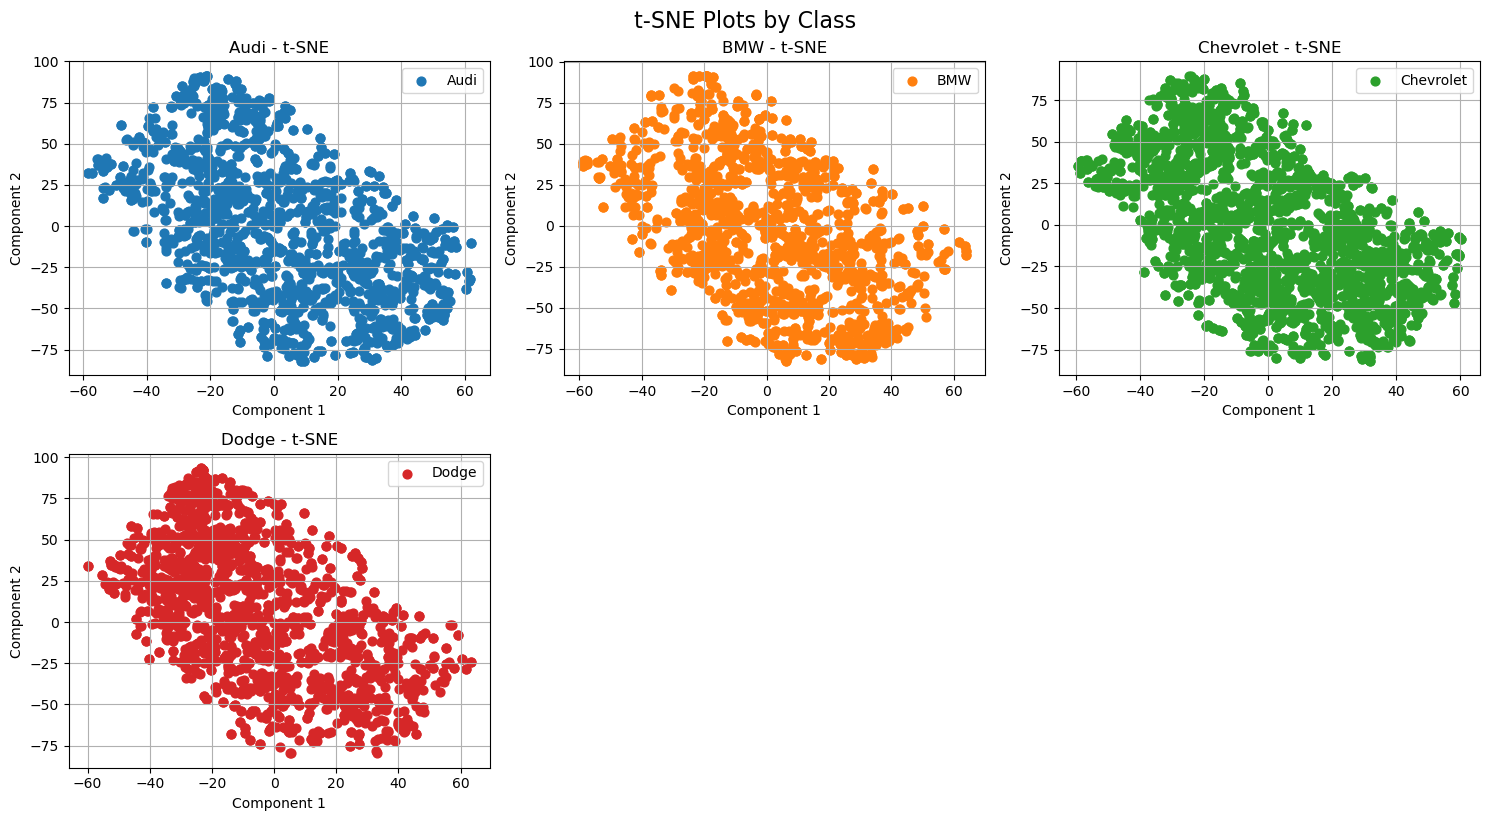

In [18]:
# Set up the figure
num_classes = len(label_names)
cols = 3
rows = int(np.ceil(num_classes / cols))
plt.figure(figsize=(cols * 5, rows * 4))

# Create a subplot for each label
for i, label in enumerate(label_names):
    plt.subplot(rows, cols, i + 1)
    mask = numeric_labels == i
    plt.scatter(tsne_results[mask, 0], tsne_results[mask, 1],
                c=[plt.cm.tab10(i)], label=label, s=40)
    plt.title(f"{label} - t-SNE")
    plt.xlabel("Component 1")
    plt.ylabel("Component 2")
    plt.grid(True)
    plt.legend()

plt.tight_layout()
plt.suptitle("t-SNE Plots by Class", fontsize=16, y=1.02)
plt.show()

C:\Users\jcf03\anaconda3\lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


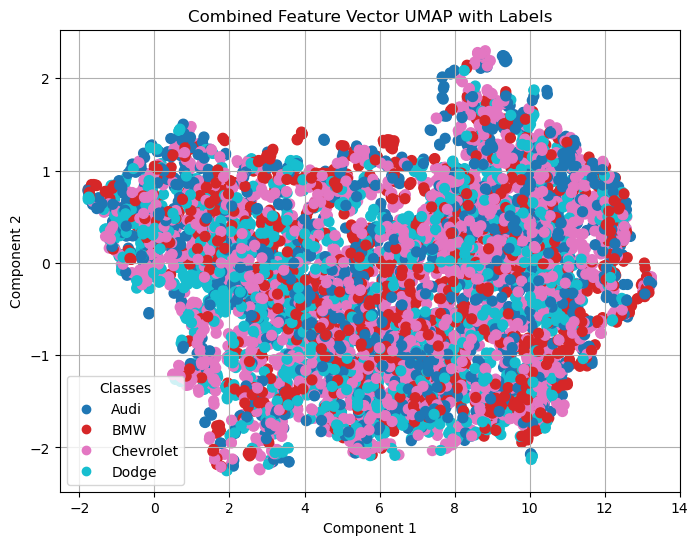

In [17]:
import umap.umap_ as umap

# Fit UMAP
umap_model = umap.UMAP(n_components=2, n_neighbors=15, min_dist=0.1, random_state=42)
umap_results = umap_model.fit_transform(train_concat_features)

# Encode labels
le = LabelEncoder()
numeric_labels = le.fit_transform(targets)
label_names = le.classes_

# Plot
plt.figure(figsize=(8, 6))
scatter = plt.scatter(umap_results[:, 0], umap_results[:, 1], c=numeric_labels, cmap='tab10', s=50)
handles, indices = scatter.legend_elements()
legend_labels = [label_names[i] for i in range(len(handles))]
plt.legend(handles, legend_labels, title="Classes")
plt.title("Combined Feature Vector UMAP with Labels")
plt.xlabel("Component 1")
plt.ylabel("Component 2")
plt.grid(True)
plt.show()

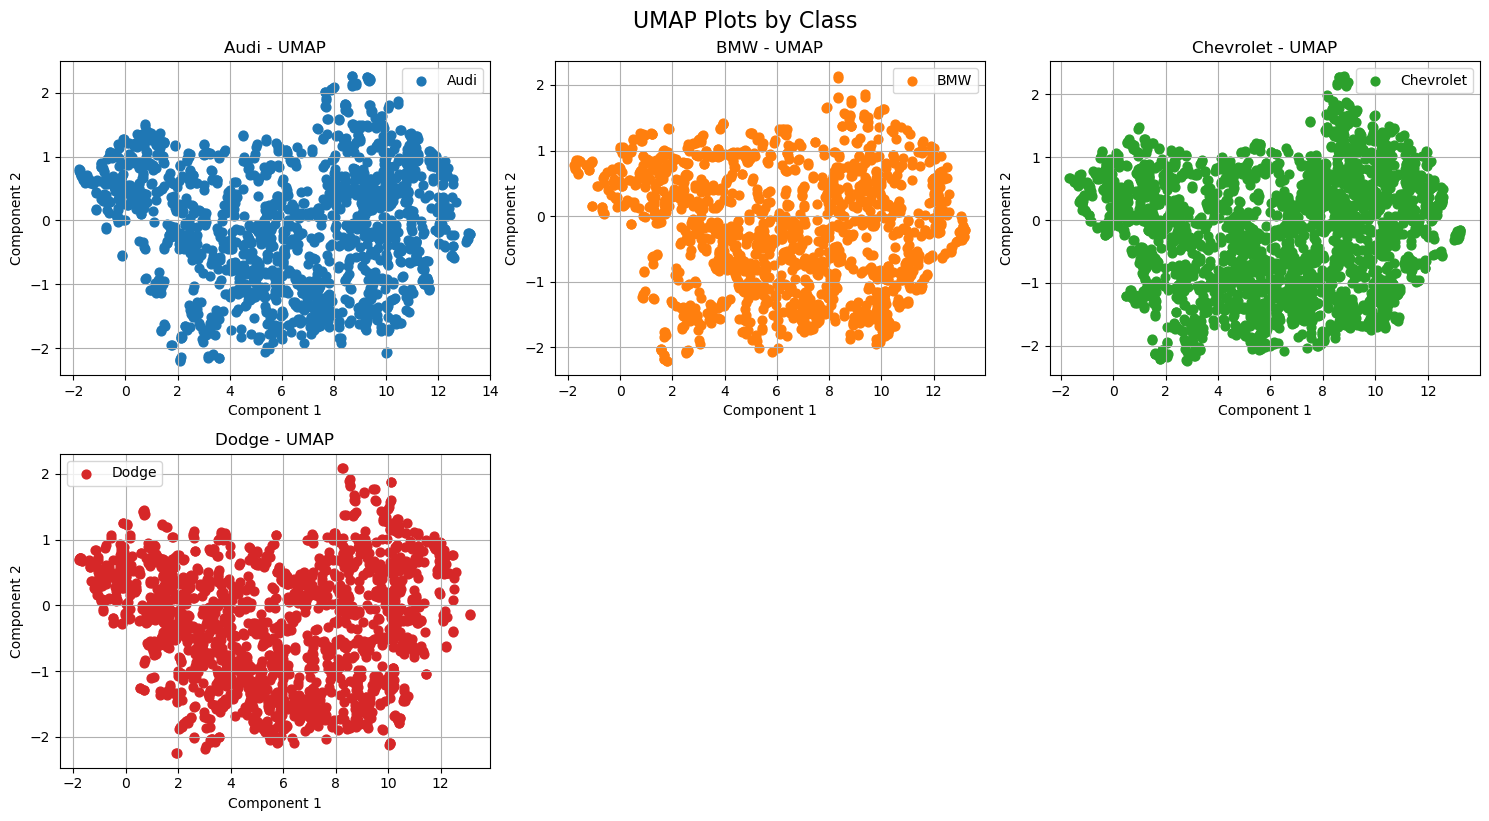

In [19]:
# Set up the figure
num_classes = len(label_names)
cols = 3
rows = int(np.ceil(num_classes / cols))
plt.figure(figsize=(cols * 5, rows * 4))

# Create a subplot for each label
for i, label in enumerate(label_names):
    plt.subplot(rows, cols, i + 1)
    mask = numeric_labels == i
    plt.scatter(umap_results[mask, 0], umap_results[mask, 1],
                c=[plt.cm.tab10(i)], label=label, s=40)
    plt.title(f"{label} - UMAP")
    plt.xlabel("Component 1")
    plt.ylabel("Component 2")
    plt.grid(True)
    plt.legend()

plt.tight_layout()
plt.suptitle("UMAP Plots by Class", fontsize=16, y=1.02)
plt.show()

In [12]:
train_flattened_fourier = np.array([img.flatten() for img in train_fourier])
train_flattened_canny = np.array([img.flatten() for img in train_canny])

test_flattened_fourier = np.array([img.flatten() for img in test_fourier])
test_flattened_canny = np.array([img.flatten() for img in test_canny])

In [15]:
train_concat_features = np.concatenate((train_hog, train_flattened_fourier, train_flattened_canny), axis=1)
test_concat_features = np.concatenate((test_hog, test_flattened_fourier, test_flattened_canny), axis=1)